<a href="https://colab.research.google.com/github/airctic/icevision/blob/master/notebooks/wandb_efficientdet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [IceVision](https://airctic.com/) meets [W&B](https://wandb.ai/)

IceVision + W&B = Agnostic Object Detection Framework with Outstanding Experiments Tracking 

IceVision fully supports W&B by providing a one-liner API that enables users to track their trained models and display both the predicted and ground truth bounding boxes.

W&B makes visualizing and tracking different models performance a highly enjoyable task. Indeed, we are able to monitor the performance of several EfficientDet backbones by changing few lines of code and obtaining very intuitive and easy-to-interpret figures that highlights both the similarities and differences between the different backbones.

For more information check the [Report](https://wandb.ai/ai-fast-track/icevision-fridge/reports/IceVision-meets-W-B--VmlldzoyODQxNjg). Note, however, that the report refers to an older version of IceVision. This tutorial is updated for IceVision 0.7.

This tutorial emphasizes the additional work required to integrated W&B. If you are new to IceVision, then we suggest that you look at the [getting started with object detection tutorial](getting_started_object_detection.ipynb).

In this tutorial, we are using the [fastai](https://github.com/fastai/fastai) library training loop, the [efficientdet]() object detection model, and a sample dataset with images of objects that you might find in a fridge. Following the usual practice with IceVision, you can use W&B with other training loops, model libraries, models and backbones. The W&B specific lines below would not need to be changed.

![](https://raw.githubusercontent.com/airctic/icevision/master/images/fridge-objects.png)

## Install IceVision and IceData
If on Colab run the following cell, else check the [installation instructions](https://airctic.com/dev/install/)

Install from pypi...

In [ ]:
# # Torch - Torchvision - IceVision - IceData - MMDetection - YOLOv5 - EfficientDet Installation
# !wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh

# # Choose your installation target: cuda11 or cuda10 or cpu
# !bash icevision_install.sh cuda11

... or from icevision master

In [ ]:
# Torch - Torchvision - IceVision - IceData - MMDetection - YOLOv5 - EfficientDet Installation
!wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh

# Choose your installation target: cuda11 or cuda10 or cpu
!bash icevision_install.sh cuda11 master

In [3]:
# Restart kernel after installation
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'restart': True, 'status': 'ok'}

## Imports

In [1]:
from icevision.all import *
from fastai.callback.wandb import *
from fastai.callback.tracker import SaveModelCallback

INFO     - Downloading default `.ttf` font file - SpaceGrotesk-Medium.ttf from https://raw.githubusercontent.com/airctic/storage/master/SpaceGrotesk-Medium.ttf to /root/.icevision/fonts/SpaceGrotesk-Medium.ttf | icevision.visualize.utils:get_default_font:70
INFO     - Downloading mmdet configs | icevision.models.mmdet.download_configs:download_mmdet_configs:31


0B [00:00, ?B/s]

## Load the Fridge Objects dataset
The fridge Objects dataset is tiny dataset that contains 134 images of 4 classes:
- can, 
- carton, 
- milk bottle, 
- water bottle.

IceVision provides very handy methods such as loading a dataset, parsing annotations, and more. 

In [2]:
# Dataset
url = "https://cvbp-secondary.z19.web.core.windows.net/datasets/object_detection/odFridgeObjects.zip"
dest_dir = "fridge"
data_dir = icedata.load_data(url, dest_dir, force_download=True)

  0%|          | 0/20380998 [00:00<?, ?B/s]

In [3]:
# Create the parser
parser = parsers.VOCBBoxParser(annotations_dir=data_dir / "odFridgeObjects/annotations", images_dir=data_dir / "odFridgeObjects/images")

In [5]:
# Parse annotations to create records
train_records, valid_records = parser.parse()
parser.class_map

  0%|          | 0/128 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/128 [00:00<?, ?it/s]

<ClassMap: {'background': 0, 'carton': 1, 'milk_bottle': 2, 'can': 3, 'water_bottle': 4}>

## Train and Validation Datasets

In [6]:
# Transforms
image_size = 384

train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=image_size, presize=512), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

In [7]:
# Datasets
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

## Create the model
In IceVision, we need to select the model type and backbone. For this tutorial, we are selecting efficientdet and the `tf_lite0` backbone. Some models require additional information, such as the `image_size`.

In [9]:
# Library and model selection

model_type = models.ross.efficientdet
backbone = model_type.backbones.tf_lite0(pretrained=True)
# The efficientdet model requires an img_size parameter
extra_args = {'img_size' : image_size}

model = model_type.model(backbone=backbone, num_classes=len(parser.class_map), **extra_args) 

Downloading: "https://github.com/rwightman/efficientdet-pytorch/releases/download/v0.1/tf_efficientdet_lite0-f5f303a9.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientdet_lite0-f5f303a9.pth


## Create the dataloaders

The dataloaders differ somewhat across the model_types, so creating them comes after selecting the model type.

In [10]:
# DataLoaders
train_dl = model_type.train_dl(train_ds, batch_size=16, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=16, num_workers=4, shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Training

## Intialize W&B

At this point, we initialize W&B. This works in the jupyter notebook, but it is more typical run W&B from within a programme. This is partly because it enables you to track the progress of your training jobs from a custom dashboard from your browser, tablet, or phone. The full interface also makes it easy to compare multiple training runs, which can be very powerful when combined with IceVision. You can easily see which model is best suited to your problem.

Initializing is a single line from the W&B library.

In [ ]:
wandb.init(project="icevision-fridge", name="efficientdet_tf_lite0", reinit=True)

## Create the learner

This tutorial is using[fastai](https://github.com/fastai/fastai), but IceVision lets you us other frameworks such as  [pytorch-lightning](https://github.com/PyTorchLightning/pytorch-lightning).

In order to use W&B within fastai, you need to specify the `WandbCallback`, which results in logging the metrics as well as other key parameters, as well as the `SaveModelCallback`, which enables W&B to log the models. Logging the model is very powerful, as it ensures that you have a copy of the best version of the model as you train. If you are using W&B on-line, however, it causes your model to be transferred to the W&B database as well as saved in a local `wandb` directory.

In [12]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, 
                                  metrics=[COCOMetric(metric_type=COCOMetricType.bbox)], 
                                  cbs=[WandbCallback(), SaveModelCallback()])

## Train

In this case, we use the `fit_one_cycle` training method from fastai, which uses a specific policy for adjusting the learning rate. This model is likely to take around 2-10 seconds per epoch, depending on your hardware. Training for 30 epochs on this small dataset typically reaches a level around 0.8 (COCOMetric), which is sufficient for our demonstration purposes and saves some time.

In [13]:
learn.fit_one_cycle(30, 1e-2)

Could not gather input dimensions
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'Dataset' object has no attribute 'items'


epoch,train_loss,valid_loss,COCOMetric,time
0,1.940700,1.267195,0.000069,00:12
1,1.685492,1.271025,0.000023,00:07
2,1.540221,1.264216,0.017094,00:07
3,1.424315,1.147959,0.155413,00:07
4,1.303290,1.082212,0.218895,00:07
5,1.184958,0.875454,0.310934,00:07
6,1.083239,0.831463,0.260008,00:07
7,0.993147,0.897370,0.278169,00:07
8,0.912498,0.779531,0.356216,00:07
9,0.844710,0.740413,0.360409,00:07


/usr/local/lib/python3.7/dist-packages/effdet/bench.py:45: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  indices_all = cls_topk_indices_all // num_classes


Better model found at epoch 0 with valid_loss value: 1.2671946287155151.
Better model found at epoch 2 with valid_loss value: 1.2642161846160889.
Better model found at epoch 3 with valid_loss value: 1.1479589939117432.
Better model found at epoch 4 with valid_loss value: 1.0822120904922485.
Better model found at epoch 5 with valid_loss value: 0.8754537105560303.
Better model found at epoch 6 with valid_loss value: 0.8314631581306458.
Better model found at epoch 8 with valid_loss value: 0.7795311808586121.
Better model found at epoch 9 with valid_loss value: 0.7404130697250366.
Better model found at epoch 10 with valid_loss value: 0.7236919403076172.
Better model found at epoch 12 with valid_loss value: 0.6536057591438293.
Better model found at epoch 14 with valid_loss value: 0.6516388654708862.
Better model found at epoch 15 with valid_loss value: 0.5437638759613037.
Better model found at epoch 16 with valid_loss value: 0.5164031982421875.
Better model found at epoch 17 with valid_loss

## Show results

We can now look athe results of the training in the notebook.

/usr/local/lib/python3.7/dist-packages/effdet/bench.py:45: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  indices_all = cls_topk_indices_all // num_classes


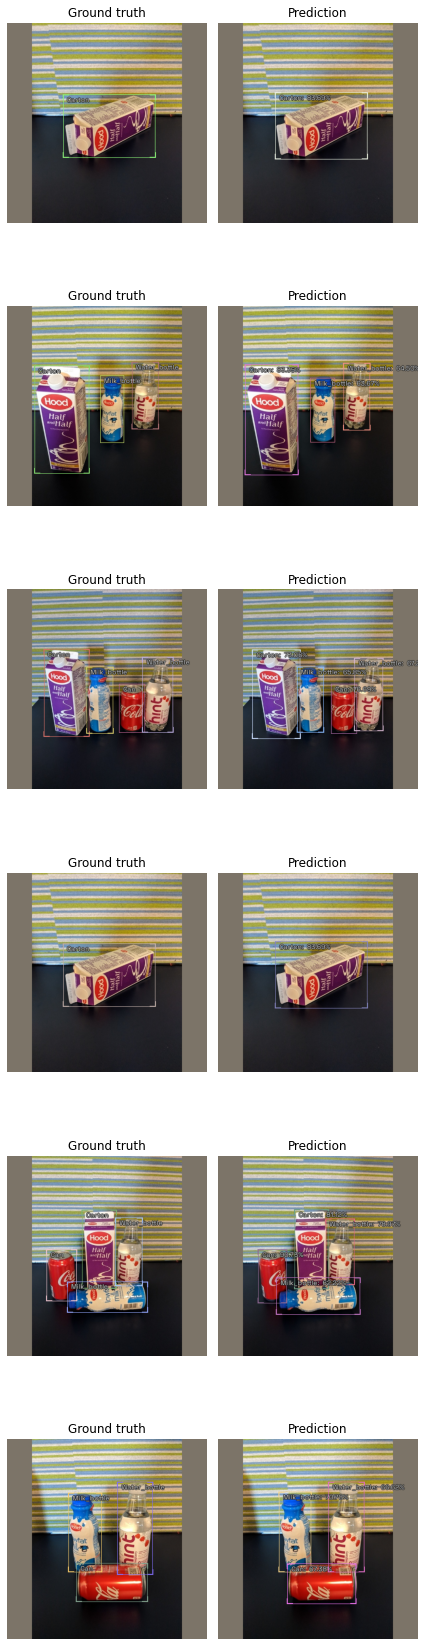

In [14]:
model_type.show_results(model, valid_ds)

## Get predictions

Let's get the list of predictions from our model. We do this by creating an `infer_dl` - a dataloader used for inference and then getting predictions from the data loader. 

Please note the `keep_images=True`. By default, the predictions include scores, labels, and bounding boxes. In our case, we want to keep the images so that we log them to W&B.

In [15]:
infer_dl = model_type.infer_dl(valid_ds, batch_size=8)
preds = model_type.predict_from_dl(model=model, infer_dl=infer_dl, keep_images=True)

  0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/effdet/bench.py:45: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  indices_all = cls_topk_indices_all // num_classes


## Log results to W&B

Now comes the most important bit of this tutorial - actually logging the predictions to W&B. This takes one line specific to icevision and a second line to send the information to W&B.

In [16]:
# Create wandb_images for each prediction
wandb_images = wandb_img_preds(preds, add_ground_truth=True) 

# Log the wandb_images to wandb
wandb.log({"Predicted images": wandb_images})

After logging and finishing the training, it is good to mark the run as completed. This can take a few seconds, as we wait for the W&B processes to transfer data and finalize logging.

In [ ]:
# optional: mark the run as completed
wandb.join()

## Happy Learning!

If you need any assistance, feel free to join our [forum](https://discord.gg/JDBeZYK).